In [0]:

!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-k6bplgj6
All libraries are successfully installed!


In [0]:

from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True)

Files already downloaded and verified


In [0]:
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
n = 0
s = np.zeros(3)
sq = np.zeros(3)
for data, l in tqdm_notebook(train):
  x = np.array(data)/255
  s += x.sum(axis=(0,1))
  sq += np.sum(np.square(x), axis=(0,1))
  n += x.shape[0]*x.shape[1]

mu = s/n
std = np.sqrt((sq/n - np.square(mu)))
print(mu, sq/n, std, n)


[0.49139968 0.48215841 0.44653091] [0.30249857 0.29176174 0.26781806] [0.24703223 0.24348513 0.26158784] 51200000


# Data Transformations with **Albumentations**

In [0]:
import numpy as np

from evadatatransforms import AlbumentationTransforms
import albumentations as A

channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
# Train Phase transformations
train_transforms = AlbumentationTransforms([
                                       A.Rotate((-30.0, 30.0)),
                                       A.HorizontalFlip(),
                                       A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                       A.Normalize(mean=channel_means, std=channel_stdevs),
                                       A.Cutout(num_holes=4) # fillvalue is 0 after normalizing as mean is 0
                                       ])

fillmeans = (np.array(channel_means)).astype(np.uint8)



# Test Phase transformations
test_transforms = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])

# Loading and Split Datasets into Train and Test

In [0]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
import dataloaders

dataloader = dataloaders.DataLoader(batch_size=128)

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

In [0]:
import numpy as np
dataiter = iter(train_loader)
images, labels = dataiter.next()
i = images[90].numpy()
print(np.max(i), np.min(i))

1.3512444 -1.9892128


torch.Size([128, 3, 32, 32])
torch.Size([128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


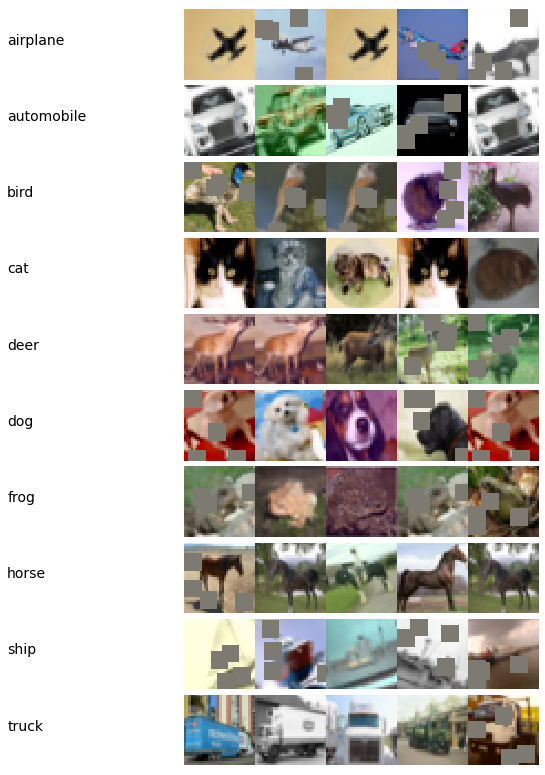

In [0]:
from __future__ import print_function
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

# **Model Summary**

In [0]:
import resnetmodel
import torch
model = resnetmodel.ResNet18()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
model.summary((3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

## **Train and Test the Model**

In [0]:

#from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
EPOCHS = 20
L2lambda = 0
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True, weight_decay=L2lambda)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=EPOCHS)
L1lambda = 0
model.gotrain(optimizer, train_loader, test_loader, EPOCHS, "/content/drive/My Drive", scheduler, True, L1lambda)

Validation loss decreased (100000.000000 --> 1.403625).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0123, Accuracy: 43.42%; Test set: Average loss: 1.4036, Accuracy: 55.85%
Learning Rate = 0.052181


Validation loss decreased (1.403625 --> 0.966846).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0090, Accuracy: 60.12%; Test set: Average loss: 0.9668, Accuracy: 67.30%
Learning Rate = 0.140093


Validation loss decreased (0.966846 --> 0.694959).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0074, Accuracy: 66.96%; Test set: Average loss: 0.6950, Accuracy: 76.74%
Learning Rate = 0.260161


Epoch: 4, Train set: Average loss: 0.0064, Accuracy: 71.98%; Test set: Average loss: 0.7082, Accuracy: 75.98%
Learning Rate = 0.380186


Validation loss decreased (0.694959 --> 0.578692).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0056, Accuracy: 75.30%; Test set: Average loss: 0.5787, Accuracy: 80.41%
Learning Rate = 0.467980


Epoch: 6, Train set: Average loss: 0.0050, Accuracy: 77.81%; Test set: Average loss: 0.6025, Accuracy: 80.30%
Learning Rate = 0.500000


Validation loss decreased (0.578692 --> 0.520659).  Saving model ...
Epoch: 7, Train set: Average loss: 0.0046, Accuracy: 79.58%; Test set: Average loss: 0.5207, Accuracy: 82.65%
Learning Rate = 0.493700


Validation loss decreased (0.520659 --> 0.504101).  Saving model ...
Epoch: 8, Train set: Average loss: 0.0042, Accuracy: 81.35%; Test set: Average loss: 0.5041, Accuracy: 82.94%
Learning Rate = 0.475180


Validation loss decreased (0.504101 --> 0.408604).  Saving model ...
Epoch: 9, Train set: Average loss: 0.0039, Accuracy: 82.70%; Test set: Average loss: 0.4086, Accuracy: 86.28%
Learning Rate = 0.445369


Epoch: 10, Train set: Average loss: 0.0036, Accuracy: 84.24%; Test set: Average loss: 0.4216, Accuracy: 85.96%
Learning Rate = 0.405761


Validation loss decreased (0.408604 --> 0.400058).  Saving model ...
Epoch: 11, Train set: Average loss: 0.0033, Accuracy: 85.55%; Test set: Average loss: 0.4001, Accuracy: 86.43%
Learning Rate = 0.358342


Epoch: 12, Train set: Average loss: 0.0030, Accuracy: 86.61%; Test set: Average loss: 0.4281, Accuracy: 86.18%
Learning Rate = 0.305491


Validation loss decreased (0.400058 --> 0.337599).  Saving model ...
Epoch: 13, Train set: Average loss: 0.0027, Accuracy: 87.81%; Test set: Average loss: 0.3376, Accuracy: 88.54%
Learning Rate = 0.249858


Epoch: 14, Train set: Average loss: 0.0025, Accuracy: 88.67%; Test set: Average loss: 0.3437, Accuracy: 89.07%
Learning Rate = 0.194231


Validation loss decreased (0.337599 --> 0.323333).  Saving model ...
Epoch: 15, Train set: Average loss: 0.0023, Accuracy: 89.96%; Test set: Average loss: 0.3233, Accuracy: 89.98%
Learning Rate = 0.141401


Validation loss decreased (0.323333 --> 0.312136).  Saving model ...
Epoch: 16, Train set: Average loss: 0.0020, Accuracy: 90.85%; Test set: Average loss: 0.3121, Accuracy: 90.19%
Learning Rate = 0.094017


Validation loss decreased (0.312136 --> 0.299768).  Saving model ...
Epoch: 17, Train set: Average loss: 0.0018, Accuracy: 92.17%; Test set: Average loss: 0.2998, Accuracy: 90.75%
Learning Rate = 0.054454


Validation loss decreased (0.299768 --> 0.272330).  Saving model ...
Epoch: 18, Train set: Average loss: 0.0016, Accuracy: 92.95%; Test set: Average loss: 0.2723, Accuracy: 91.50%
Learning Rate = 0.024697


Epoch: 19, Train set: Average loss: 0.0014, Accuracy: 93.94%; Test set: Average loss: 0.2728, Accuracy: 91.47%
Learning Rate = 0.006238


Epoch: 20, Train set: Average loss: 0.0013, Accuracy: 94.18%; Test set: Average loss: 0.2740, Accuracy: 91.67%
Learning Rate = 0.000002



# Implementing **Gradcam**

In [0]:

import cv2
import urllib
import numpy as np
from google.colab.patches import cv2_imshow

def getimage(img, transform, input_size=(32,32)):
  if img.startswith("http"):
      req = urllib.request.urlopen(img)
      arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
      img = cv2.imdecode(arr, -1) # 'Load it as it is'
  else:
    img = cv2.imread(img, 1)
  
  img = img[:,:, -1::-1]
  
  img = np.uint8(cv2.resize(img, input_size))

  return transform(img)

In [0]:
in_images = [
          (0, 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fb/Egyptair.a330-200.su-gce.arp.jpg/1200px-Egyptair.a330-200.su-gce.arp.jpg'),
          (1, 'https://upload.wikimedia.org/wikipedia/commons/5/5b/Riley_4-68_Riviera_1961.jpg'),
          (2, 'https://upload.wikimedia.org/wikipedia/commons/4/45/Eopsaltria_australis_-_Mogo_Campground.jpg'),
          (3, 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Cat_November_2010-1a.jpg/800px-Cat_November_2010-1a.jpg'),
          (4, 'https://upload.wikimedia.org/wikipedia/commons/thumb/d/d7/Spotted_deer_in_S.V._zoo%2C_Tirupathi_%28May_2019%29.jpg/1920px-Spotted_deer_in_S.V._zoo%2C_Tirupathi_%28May_2019%29.jpg'),
          (5, 'https://upload.wikimedia.org/wikipedia/commons/thumb/7/75/%22Boxer_dog%22_stand.jpg/1280px-%22Boxer_dog%22_stand.jpg'),
          (6, 'https://upload.wikimedia.org/wikipedia/commons/thumb/c/c1/Variegated_golden_frog_%28Mantella_baroni%29_Ranomafana.jpg/800px-Variegated_golden_frog_%28Mantella_baroni%29_Ranomafana.jpg'),
          (7, 'https://upload.wikimedia.org/wikipedia/commons/thumb/7/7b/Horseracing_Churchill_Downs.jpg/1920px-Horseracing_Churchill_Downs.jpg'),
          (8, 'https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Marina_%28ship%2C_2011%29%2C_S%C3%A8te_01.jpg/1920px-Marina_%28ship%2C_2011%29%2C_S%C3%A8te_01.jpg'),
          (9, 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/b2/Bergingstruck_%28tow_truck%29.jpg/1280px-Bergingstruck_%28tow_truck%29.jpg')
]
#
images = []
target_classes = []

for i in in_images:
  images.append(getimage(i[1], test_transforms))
  target_classes.append(i[0])
#class_names = ['airplane','automobile','bird','cat','deer',
#               'dog','frog','horse','ship','truck']

In [0]:
model.load_state_dict(torch.load(f"/content/drive/My Drive/{model.name}.pt"))

<All keys matched successfully>

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


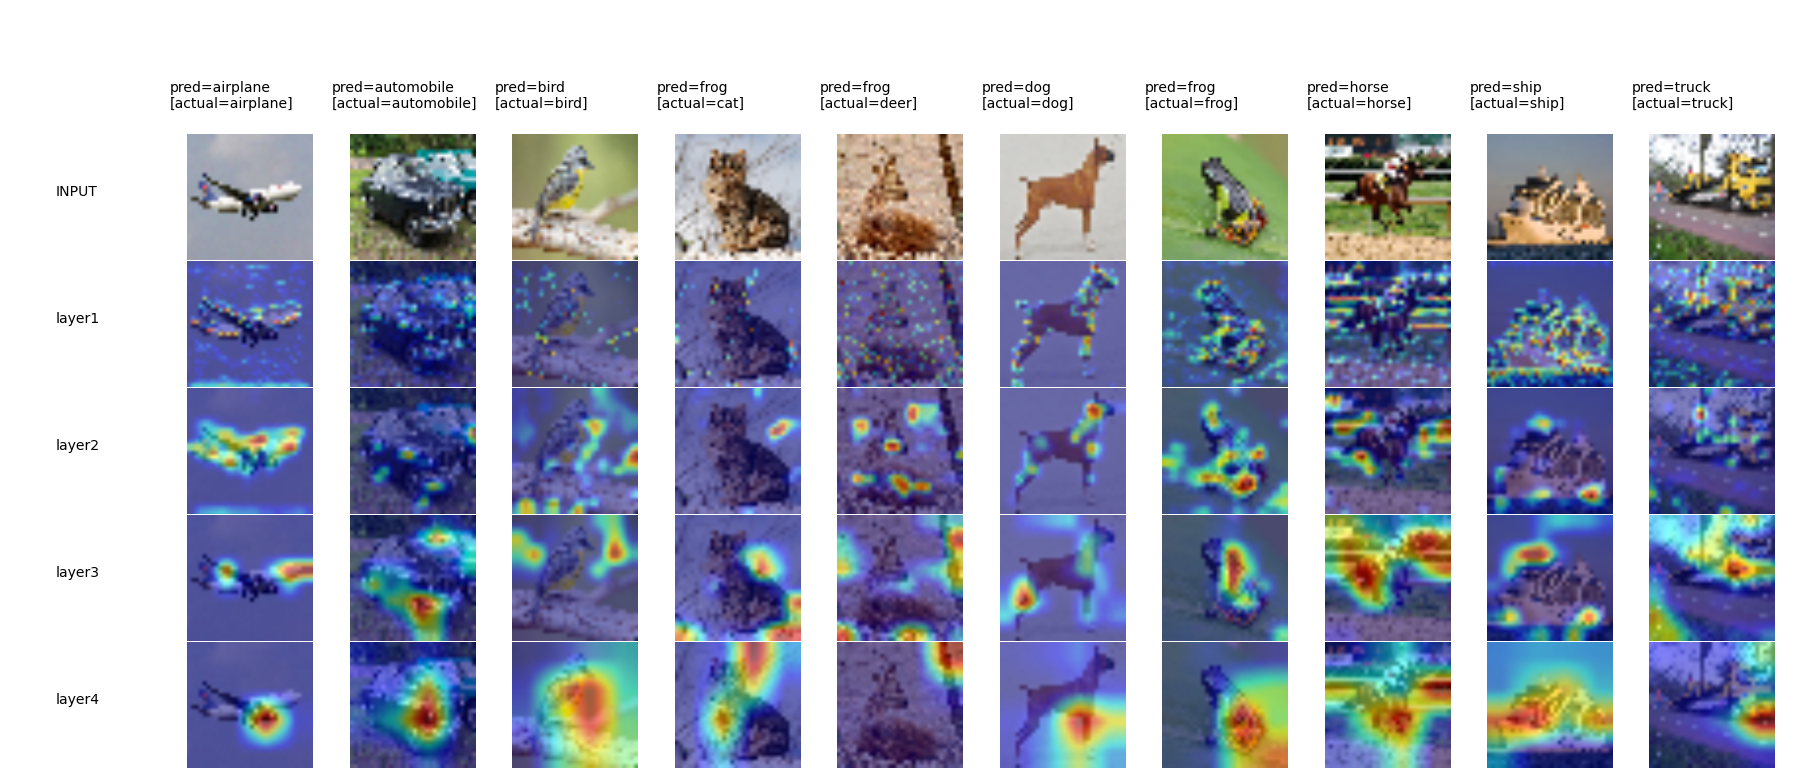

In [0]:

from gradcam import GRADCAM, PLOT
target_layers = ["layer1", "layer2", "layer3", "layer4"]
gradcam_output, probs, predicted_classes = GRADCAM(images, target_classes, model, target_layers)
PLOT(gradcam_output, images, target_classes, target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)

Submitted by G Uday Kiran and Srilakshmi V